<Axes: xlabel='Date'>

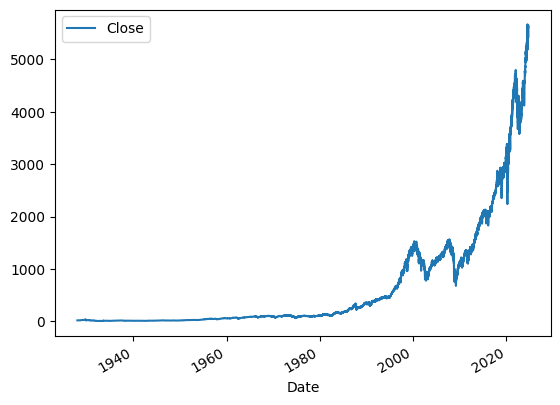

In [34]:
# Call the yahoo finance API to download daily stock index prices
import yfinance as yf
# Initialize ticker class to download price history for symbol "VOO" (S&P 500 Vanguard ETF)
sp500 = yf.Ticker("^GSPC")
# Query historical prices (from when the index was created)
sp500 = sp500.history(period = "max")
# Plot the closing price against the index
sp500.plot.line(y="Close", use_index=True)





In [35]:
# Do not need Dividends, Capital Gains, and Stock Splits because this is an index fund
del sp500["Dividends"]
del sp500["Stock Splits"]
# Take the close call and shift all the prices back by one day
sp500["Tomorrow"] = sp500["Close"].shift(-1)
# Target: WHat we try to predict with ML
# Is tomorrow's price greater than today's price?
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
# Remove all data from before 1990 to reduce interference of fundamental shifts
sp500 = sp500.loc["1990-01-01":].copy()
# This model works by training a number of individual decision trees with randomized params
# Results are averaged. Random forests are resistant to overfitting. Also runs quickly and
# picks up nonlinear trends.
from sklearn.ensemble import RandomForestClassifier
# n_estimators:number of individual decision trees to train. Higher, the better.
# min_samples_split: protects against overfitting, which can happen if decision tree
# is built too deeply. Higher it is, the less accurate the model will be.
# random_state: if we run the same model twice, the random numbers generated will be
# ina predictable sequence.
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)
# Split data into train and test set. Can't use cross validation with time set, since we will be
# using future data to predict the past. This leakage leaks data into the model.
# All rows except last 100 rows into training set. Last 100 rows in test set.
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
# Do not use tomorrow or target column. Model can't know the future.
predictors = ["Close", "Volume", "Open","High","Low"]
# Train the model
model.fit(train[predictors], train["Target"])
# Measure how accurate the model is
from sklearn.metrics import precision_score
# When we said the target was 1, did the stock actually go up?
preds = model.predict(test[predictors])
# predictions in numpy array. Turn into pandas series.
import pandas as pd
import numpy as np
preds = pd.Series(preds, index = test.index)



In [36]:
precision_score(test["Target"], preds).item()

0.5714285714285714

<Axes: xlabel='Date'>

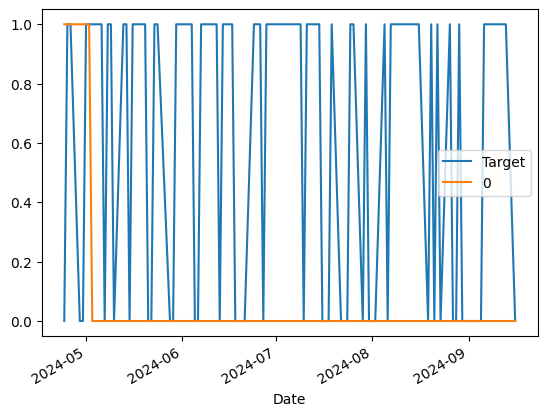

In [37]:
# Plot predictions. Treat each input as a column.
combined = pd.concat([test["Target"],preds], axis = 1)
combined.plot()

In [38]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [39]:
# Want to have a certain amount of data to train models. Train model with 10 years of data.
def backtest(data,model,predictors,start=2500,step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [40]:
predictions = backtest(sp500, model, predictors)

In [41]:
predictions["Predictions"].value_counts()

Predictions
0    3647
1    2596
Name: count, dtype: int64

In [42]:
precision_score(predictions["Target"], predictions["Predictions"]).item()

0.5288906009244992

In [43]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.53564
0    0.46436
Name: count, dtype: float64

In [44]:
# Create more predictors. Rolling mean close prices in the last 2 days, last week,
# last 3 months, last year, and last four years
horizons = [2,5,60,250,1000]

new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    # Create close ratio columns and add to dataset
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"]/rolling_averages["Close"]
    # Look at the number of days in a time frame that the stock price went up
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


In [45]:
sp500 = sp500.dropna()

In [46]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09 00:00:00-04:00,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,1.0,0.995066,34.0,1.096431,143.0,1.260025,525.0
2024-09-10 00:00:00-04:00,5490.509766,5497.910156,5441.720215,5495.520020,3848180000,5554.129883,1,1.002231,2.0,1.002888,2.0,0.999330,34.0,1.100423,144.0,1.265038,526.0
2024-09-11 00:00:00-04:00,5496.419922,5560.410156,5406.959961,5554.129883,3839450000,5595.759766,1,1.005304,2.0,1.012325,3.0,1.009613,35.0,1.111192,144.0,1.277872,527.0


In [47]:
# Change some model params
model = RandomForestClassifier(n_estimators = 200, min_samples_split=50, random_state=1)

In [48]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    # Set custom threshold. Model goes up if 60% chance or more that it will go up.
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [49]:
predictions = backtest(sp500, model, new_predictors)

In [50]:
predictions["Predictions"].value_counts()

Predictions
0.0    4396
1.0     846
Name: count, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"]).item()

0.574468085106383